##Metrics

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

        
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
smooth=1.

# Rooftop Dataset

##Getting Data

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p My Drive
!google-drive-ocamlfuse My Drive


!ls My Drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > My Drive/created.txt



In [4]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [8]:
!ls

adc.json  Drive  My  sample_data


In [0]:
train_dir="Drive/dtst2/Train/"
test_dir='Drive/dtst2/Test/'
num=int(len(os.listdir(train_dir+'Roofs/')))
nm=int(len(os.listdir(train_dir+'Annotations/')))
n_test=int(len(os.listdir(test_dir+'Roofs/')))

In [0]:
def get_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((num, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((num, IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)

    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    """if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
        a = Progbar(180)#length of dataset size goes in"""
    


    
##Training Satell. Images
    print('Roof Images:')
    a = Progbar(num)#length of dataset size goes in
    n=0
    for img in sorted(os.listdir(train_dir+'roofs/')):
      img=imread(train_dir+'roofs/'+img)
      img = resize( img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_train[n] = img
      a.update(n)
      n=n+1
      
##Training Masks##
    
    print('Mask Images:')
    b = Progbar(nm)
    n=0
    a=sorted(os.listdir(train_dir+'Annotations/'))
    for fold in a:
      mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
      for mg in sorted(os.listdir(train_dir+'Annotations/'+fold)):
        mg=imread(train_dir+'Annotations/'+fold+"/"+mg)
        mg =resize(mg, (256, 256,1), mode='constant', preserve_range=True) #np.expand_dims(resize(mg, (256, 256), mode='constant', preserve_range=True),axis=-1) 
        mask = np.maximum(mask, mg)

      Y_train[n] = mask
      b.update(n)
      n=n+1
      

    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [11]:

train_img,train_mask = get_train_data()

Getting and resizing train images and masks ... 
Roof Images:
53/54 [============================>.] - ETA: 1s

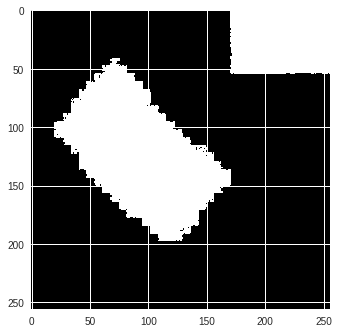

In [14]:
mg =np.squeeze(train_mask[1],axis=-1)
b=np.invert(mg)
plt.imshow(b)

###Sanity check

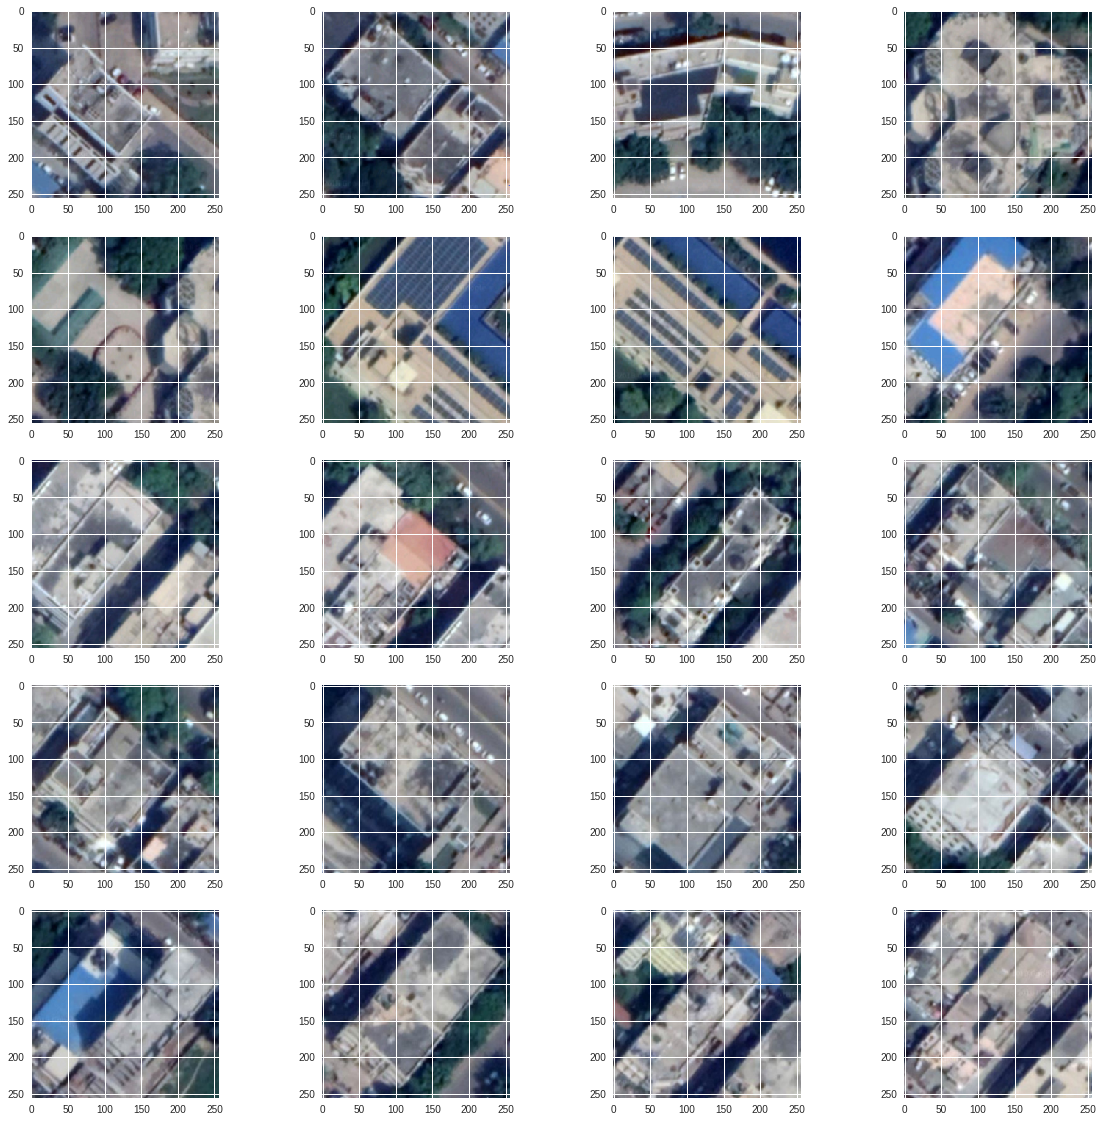

In [15]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = train_img[i]
    fig.add_subplot(rows, columns,i)
    plt.imshow(img)
plt.show()


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


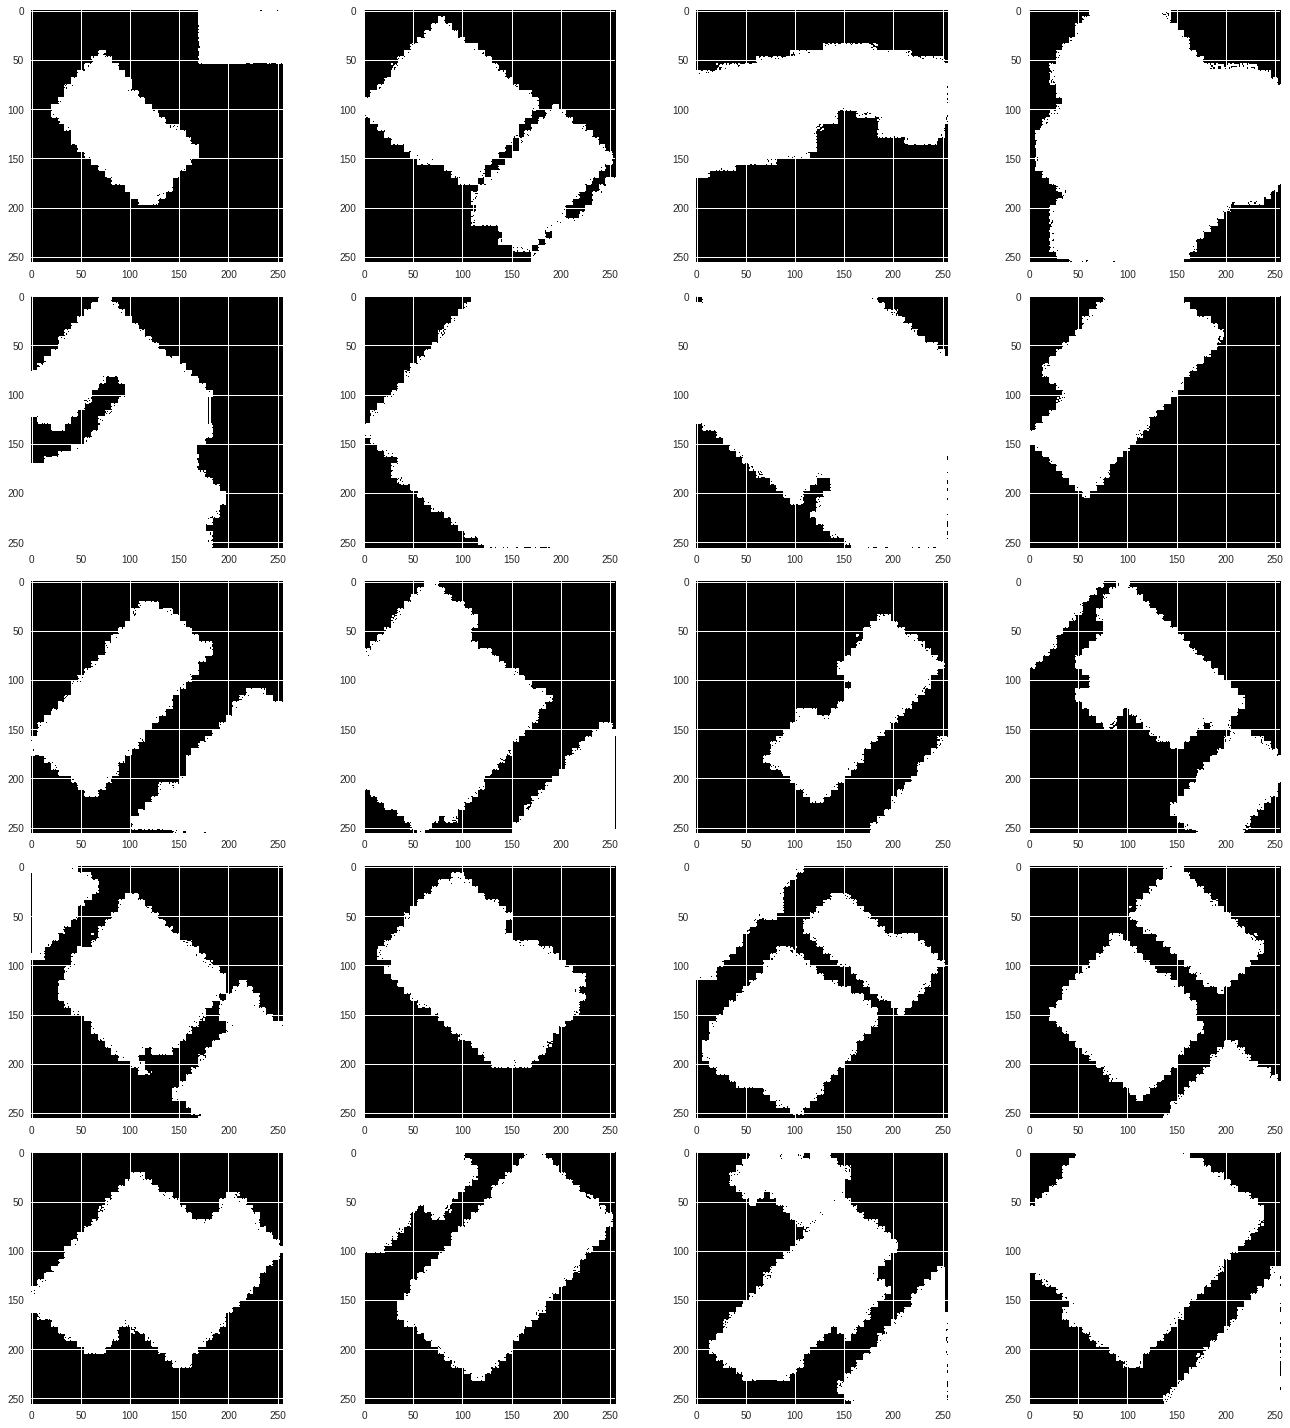

In [16]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    mg =np.squeeze(resize(train_mask[i], (256, 256), mode='constant', preserve_range=True),axis=-1)
    fig.add_subplot(rows, columns,i)
    #b=np.invert(mg)
    imshow(mg)
plt.show()



/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


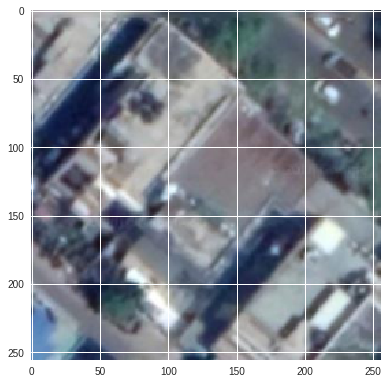

In [17]:
imshow(train_img[12])

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


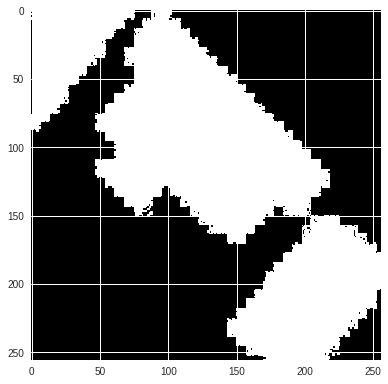

In [18]:
mg =np.squeeze(train_mask[12],axis=-1) 

imshow(mg)

## Model Training

In [0]:
def unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / 255) (inputs)
  c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
  c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
  c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
  c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
  c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
  c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

  u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
  c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

  u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
  c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

  u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
  c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

  u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
  c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
  model.summary()
  return model

In [21]:
umodel= unet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### Second Training

In [33]:
print("\nTraining...")
umodel.fit(train_img,train_mask,batch_size=16,epochs=15)


Training...
Epoch 1/15
54/54 [==============================] - 1s 17ms/step - loss: 0.4171 - dice_coef: 0.7191
Epoch 2/15
54/54 [==============================] - 1s 14ms/step - loss: 0.4138 - dice_coef: 0.7487
Epoch 3/15
54/54 [==============================] - 1s 14ms/step - loss: 0.4159 - dice_coef: 0.7050
Epoch 4/15
54/54 [==============================] - 1s 14ms/step - loss: 0.4102 - dice_coef: 0.7504
Epoch 5/15
54/54 [==============================] - 1s 14ms/step - loss: 0.3959 - dice_coef: 0.7474
Epoch 6/15
54/54 [==============================] - 1s 14ms/step - loss: 0.3940 - dice_coef: 0.7344
Epoch 7/15
54/54 [==============================] - 1s 14ms/step - loss: 0.3813 - dice_coef: 0.7552
Epoch 8/15
54/54 [==============================] - 1s 14ms/step - loss: 0.3727 - dice_coef: 0.7515
Epoch 9/15
54/54 [==============================] - 1s 14ms/step - loss: 0.3643 - dice_coef: 0.7612
Epoch 10/15
54/54 [==============================] - 1s 14ms/step - loss: 0.3776 - dice

In [22]:
print("\nTraining...")
umodel.fit(train_img,train_mask,batch_size=16,epochs=50)


Training...
Epoch 1/50
54/54 [==============================] - 5s 98ms/step - loss: 0.6919 - dice_coef: 0.4965
Epoch 2/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6900 - dice_coef: 0.4997
Epoch 3/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6867 - dice_coef: 0.5031
Epoch 4/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6812 - dice_coef: 0.5069
Epoch 5/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6707 - dice_coef: 0.5146
Epoch 6/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6501 - dice_coef: 0.5263
Epoch 7/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6127 - dice_coef: 0.5571
Epoch 8/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6330 - dice_coef: 0.5813
Epoch 9/50
54/54 [==============================] - 1s 14ms/step - loss: 0.7183 - dice_coef: 0.6458
Epoch 10/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6243 - dice

##Get Test

In [0]:

def get_test(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    #X_test = np.zeros( , IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    X_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
    Y_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
    print('\n Test Roof images ... ')
    sys.stdout.flush()
    
    p = Progbar(n_test)
    n=0
    for img in sorted(os.listdir(test_dir+'Roofs/')):
      img=imread(test_dir+'Roofs/'+img)
      img = resize( img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_test[n] = np.squeeze(img) 
      p.update(n)
      n=n+1
      
      
      
      
    print('\n Test Mask Images:')
    print('Mask Images:')
    q = Progbar(n_test)
    n=0
    a=sorted(os.listdir(test_dir+'Annotations/'))
    for fold in a:
      mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
      for mg in sorted(os.listdir(test_dir+'Annotations/'+fold)):
        mg=imread(test_dir+'Annotations/'+fold+"/"+mg)
        mg =resize(mg, (256, 256,1), mode='constant', preserve_range=True) #np.expand_dims(resize(mg, (256, 256), mode='constant', preserve_range=True),axis=-1) 
        mask = np.maximum(mask, mg)

      Y_test[n] = mask
      q.update(n)
      n=n+1
    
    
    """b = Progbar(n_test)
    n=0
    a=sorted(os.listdir(test_dir+'mask_aug/'))
    for mg in a:
      mg=imread(test_dir+'mask_aug/'+mg)
      mg =resize(mg, (256, 256,1), mode='constant', preserve_range=True) 
      Y_test[n] = mg
      b.update(n)
      n=n+1"""
    np.save("test_img",X_test)
    np.save("test_mask",Y_test)
    return X_test,Y_test


In [25]:
test_img,test_mask= get_test()


 Test Roof images ... 
5/6 [========================>.....] - ETA: 0s
 Test Mask Images:
Mask Images:
5/6 [========================>.....] - ETA: 1s

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


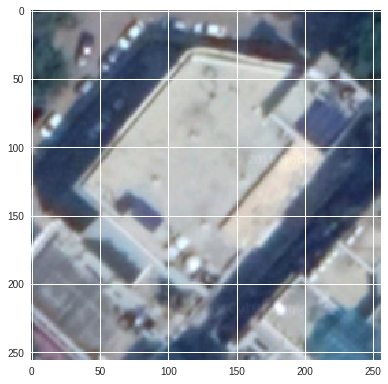

In [26]:
imshow( test_img[1])

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


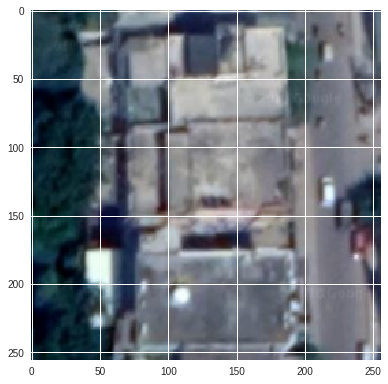

In [40]:
imshow( test_img[3])

In [32]:
np.shape(test_img_aug[3])

(256, 256, 3)

##Predictions (U-Net)

In [0]:
predum= umodel.predict(test_img,batch_size=6)

In [0]:
predum2= umodel.predict(test_img,batch_size=6)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


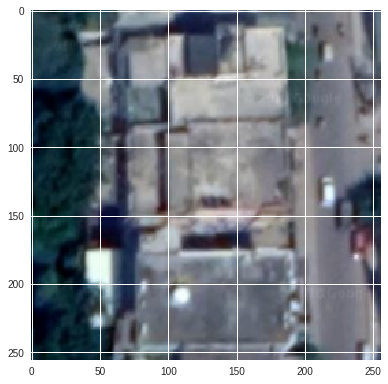

In [28]:

imshow(test_img[3])


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


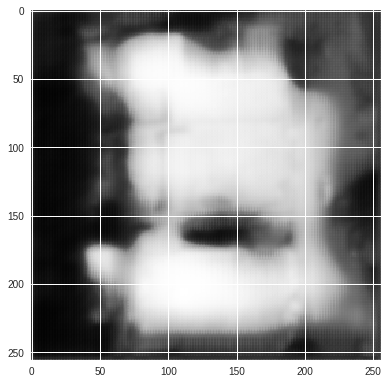

In [29]:

mg =np.squeeze( predum[3],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


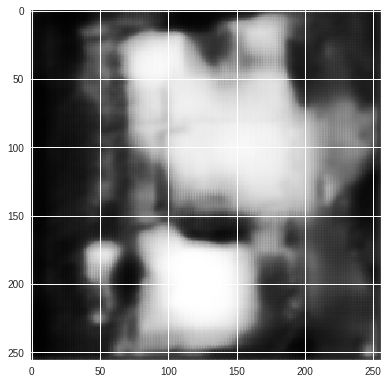

In [37]:

mg =np.squeeze( predum2[3],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


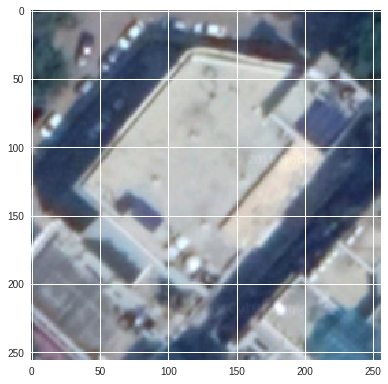

In [30]:
imshow(test_img[1])


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


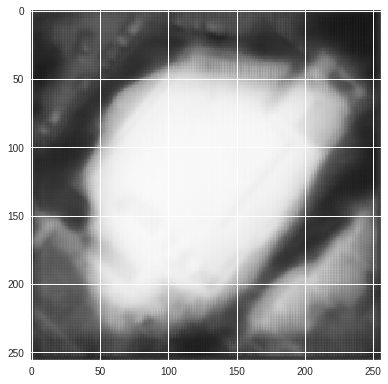

In [31]:
mg =np.squeeze( predum[1],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


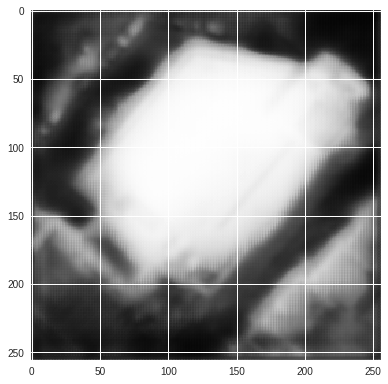

In [35]:
mg =np.squeeze( predum2[1],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


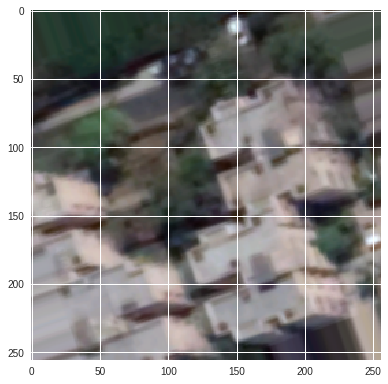

In [0]:
imshow(test_img_aug[6])


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


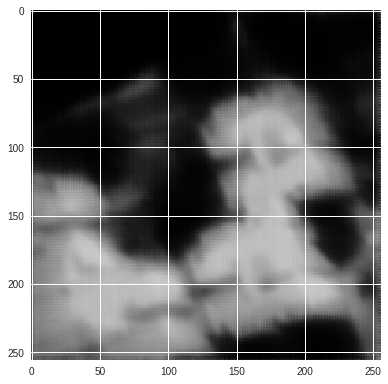

In [0]:
mg =np.squeeze(pred_aug[6],axis=-1)
imshow(mg)

##Eval (U-Net)

In [32]:
umodel.evaluate(x= test_img,y= predum )

6/6 [==============================] - 0s 43ms/step


[0.46046438813209534, 0.7055211067199707]

## Eval after 2nd Training

In [36]:
umodel.evaluate(x= test_img,y= predum2 )

6/6 [==============================] - 0s 7ms/step


[0.4300079047679901, 0.7072095274925232]

## Results
### 50 epochs
*   Train  ---> loss: 0.4362 - dice_coef: 0.7129
*   Test  --->   loss: 0.4604 - dice_coef:0.7055

### 65 epochs
*   Train  --->loss: 0.3504 - dice_coef: 0.7792
*   Test  --->  loss:0.4300 - dice_coef: 0.7072


***~~ Well Clearly the loss decreased but the model overfitted the data~~*** 